In [1]:
# ! pip install requests tqdm yfinance quantstats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf
import pandas as pd
import requests

start = '2006-01-01'
end = '2024-01-01'

benchmark = 'NQ=F'

ldf = pd.read_html(requests.get('https://www.slickcharts.com/nasdaq100', headers={'User-agent': 'Mozilla/5.0'}).text)
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]

data = yf.download([*symbols, benchmark], start, end, group_by='ticker')

[*********************100%%**********************]  102 of 102 completed


In [4]:
data[['AAPL','MSFT']].tail()

AAPL                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.600006   
2023-12-26  193.610001  193.889999  192.830002  193.050003  193.050003   
2023-12-27  192.490005  193.500000  191.089996  193.149994  193.149994   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.580002   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.529999   

                              MSFT                                      \
                Volume        Open        High         Low       Close   
Date                                                                     
2023-12-22  37122800.0  373.679993  375.179993  372.709991  374.579987   
2023-12-26  28919300.0  375.000000  376.940002  373.500000  374.660004   
2023-12-27  48087700.0  373.690002  375.059998  372.809998  374.070007   
2023-12-28  34049900.0  375.369995  376.459991  374.160004  375.279999   
2023-12-29  42628800.0  376.000000  377.160004  373.480011  376.040009   

                                    
             Adj Close      Volume  
Date                                
2023-12-22  374.579987  17091100.0  
2023-12-26  374.660004  12673100.0  
2023-12-27  374.070007  14905400.0  
2023-12-28  375.279999  14327000.0  
2023-12-29  376.040009  18723000.0

In [5]:
from btlib import Strategy

def EMA(ser: pd.Series, period: int):
    return ser.ewm(span=period, adjust=False).mean().values

class EMACrossoverStrategy(Strategy):
    buy_at_once_size = .01 # 1%

    def init(self, fast_period: int, slow_period: int):
        self.fast_period = fast_period
        self.slow_period = slow_period

        self.ma = {}
        for symbol in symbols:
            for period in [self.fast_period, self.slow_period]:
                self.ma[(symbol, period)] = EMA(self.data[(symbol, 'Close')], period)

    def next(self, i, record):
        for symbol in symbols:
            if self.ma[(symbol, self.fast_period)][i-1] > self.ma[(symbol, self.slow_period)][i-1]:
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=self._positionSize(record[(symbol,'Open')]))
            else:
                self.close(symbol=symbol, price=record[(symbol,'Open')])

    def _positionSize(self, price: float):
        return round((self.cash + self.cash_stock_value) / price * self.buy_at_once_size) if price > 0 else 0

In [6]:
from btlib import Backtest
backtest = Backtest(EMACrossoverStrategy, data, commission=.001, cash=1e6)

In [7]:
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Fast EMA','Slow EMA']
values = [[5, 10, 15, 20, 25], [30, 35, 40, 45, 50]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns[0], returns[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


In [8]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Fast EMA Slow EMA                                                         
25       45           1.004972e+06       1.994555e+07        -39.352109   
         50           1.005008e+06       1.861105e+07        -37.928419   
15       45           1.005062e+06       1.830132e+07        -39.170871   
20       50           1.004972e+06       1.705069e+07        -39.243142   
10       45           1.005602e+06       1.581151e+07        -41.488900   
25       40           1.004972e+06       1.608967e+07        -40.393660   
         35           1.004972e+06       1.587659e+07        -39.720446   
5        35           1.005510e+06       1.457832e+07        -47.087012   
15       40           1.005513e+06       1.552195e+07        -39.701878   
20       40           1.005062e+06       1.543976e+07        -39.810717   
         30           1.005513e+06       1.539042e+07        -41.679794   
         45           1.004972e+06       1.520282e+07        -41.480892   
15       30           1.005513e+06       1.398202e+07        -40.660826   
         35           1.005513e+06       1.448991e+07        -41.467014   
25       30           1.004973e+06       1.500409e+07        -41.007773   
10       40           1.005513e+06       1.344468e+07        -40.570696   
20       35           1.004973e+06       1.437994e+07        -42.701980   
10       50           1.005602e+06       1.311729e+07        -41.792290   
15       50           1.005062e+06       1.357203e+07        -40.126039   
10       35           1.005642e+06       1.235128e+07        -42.843390   
         30           1.005510e+06       1.200550e+07        -44.799464   
5        50           1.005578e+06       1.153250e+07        -44.067279   
         30           1.005164e+06       9.870033e+06        -49.870035   
         40           1.005599e+06       9.626348e+06        -44.610572   
         45           1.005599e+06       9.440897e+06        -46.200691   

                    CAGR (%)  Sharpe Ratio  
Fast EMA Slow EMA                           
25       45        18.060597      0.883589  
         50        17.606955      0.868310  
15       45        17.496989      0.859425  
20       50        17.036369      0.850260  
10       45        16.542672      0.843118  
25       40        16.659720      0.833769  
         35        16.573331      0.831108  
5        35        16.018613      0.830648  
15       40        16.423617      0.828115  
20       40        16.392177      0.825542  
         30        16.368582      0.822954  
         45        16.292783      0.821614  
15       30        15.749681      0.815950  
         35        15.979385      0.814761  
25       30        16.207785      0.813081  
10       40        15.497911      0.807963  
20       35        15.933758      0.803555  
10       50        15.339245      0.793039  
15       50        15.561305      0.790350  
10       35        14.954013      0.786210  
         30        14.773627      0.775861  
5        50        14.517141      0.769090  
         30        13.533501      0.744781  
         40        13.373184      0.725713  
         45        13.250707      0.718192

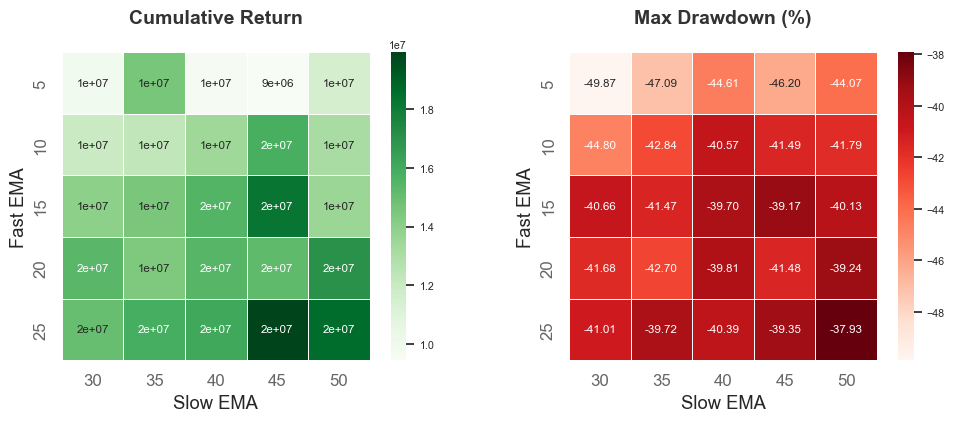

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [10]:
best_params = optimization_results_sorted.index[0]
best_params

(25, 45)

In [11]:
result = backtest.run(*best_params)

In [12]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark=data[benchmark]['Close'])

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2006-01-03  2006-01-03
End Period          2023-12-29  2023-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   1,884.69%   905.52%
CAGR﹪              18.06%      13.68%

Sharpe              0.88        0.69
Prob. Sharpe Ratio  99.99%      99.82%
Sortino             1.25        0.97
Sortino/√2          0.89        0.69
Omega               1.17        1.17

Max Drawdown        -39.35%     -53.85%
Longest DD Days     903         1161

Gain/Pain Ratio     0.17        0.14
Gain/Pain (1M)      1.1         0.83

Payoff Ratio        0.91        0.87
Profit Factor       1.17        1.14
Common Sense Ratio  1.08        1.04
CPC Index           0.59        0.55
Tail Ratio          0.92        0.92
Outlier Win Ratio   3.9         4.02
Outlier Loss Ratio  3.86        3.92

MTD                 2.76%       6.49%
3M                  11.25%      1

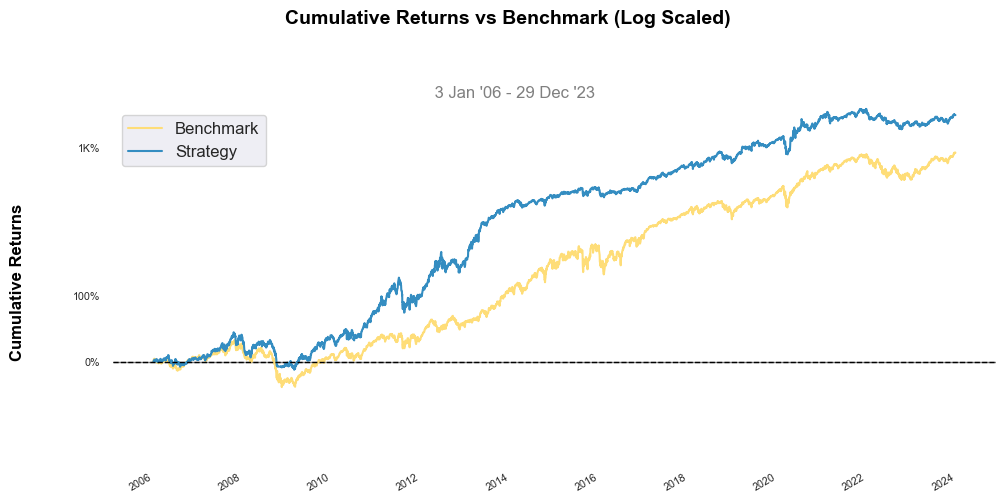

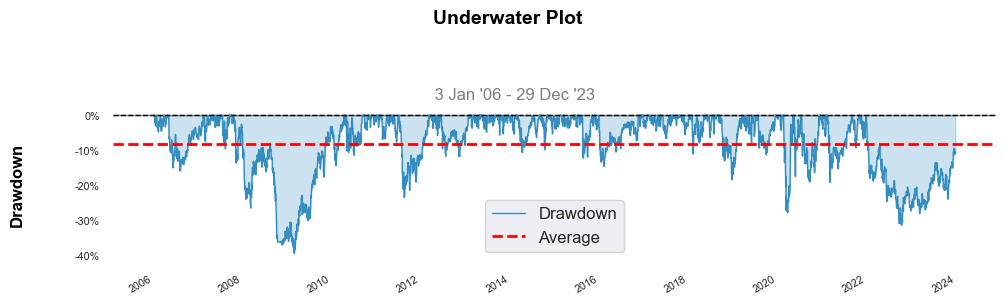

In [13]:
qs.plots.log_returns(result.returns, benchmark=data[benchmark]['Close'])
qs.plots.drawdown(result.returns, figsize=(10,3))

In [14]:
trades = pd.DataFrame(result.trades)
trades.tail(15)

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
6468,CDW,2023-10-11,2023-11-02,211.149994,200.210007,876,-9583.428772,-5.181145,360.351361,1.643066e+07
6469,CDW,2023-10-26,2023-11-02,198.500000,200.210007,872,1491.125854,0.861464,347.675126,1.643181e+07
6470,CDW,2023-10-27,2023-11-02,197.649994,200.210007,867,2219.531113,1.295225,344.944621,1.643368e+07
6471,GILD,2023-10-19,2023-11-17,79.070000,74.889999,2308,-9647.440704,-5.286455,355.339678,1.642368e+07
6472,GILD,2023-11-01,2023-11-17,79.000000,74.889999,2195,-9021.451340,-5.202532,337.788549,1.641432e+07
6473,VRTX,2023-09-26,2023-11-29,350.000000,347.500000,511,-1277.500000,-0.714286,356.422500,1.641268e+07
6474,VRTX,2023-10-19,2023-11-29,367.549988,347.500000,496,-9944.793945,-5.455037,354.664794,1.640238e+07
6475,VRTX,2023-11-01,2023-11-29,364.950012,347.500000,475,-8288.755798,-4.781480,338.413756,1.639376e+07
6476,FANG,2023-08-18,2023-12-04,146.039993,152.720001,1223,8169.649704,4.574095,365.383473,1.640156e+07
6477,FANG,2023-09-20,2023-12-04,154.600006,152.720001,1180,-2218.405762,-1.216045,362.637609,1.639898e+07


In [15]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,SNPS,2022-12-27,2023-12-29,320.790009,514.909973,515,99971.781769,60.513096,265178.636169
1,META,2023-01-10,2023-12-29,127.269997,353.959991,1314,297870.653183,178.117389,465103.428772
2,SNPS,2023-01-10,2023-12-29,324.559998,514.909973,515,98030.237427,58.648625,265178.636169
3,SNPS,2023-03-14,2023-12-29,361.339996,514.909973,447,68645.779633,42.500132,230164.757996
4,SNPS,2023-05-11,2023-12-29,370.470001,514.909973,455,65720.187225,38.988304,234284.037781
...,...,...,...,...,...,...,...,...,...
87,SIRI,2023-12-04,2023-12-29,4.850000,5.470000,39940,24762.795429,12.783503,218471.791620
88,AAPL,2023-12-05,2023-12-29,190.210007,192.529999,1008,2338.552002,1.219700,194070.238770
89,MSFT,2023-12-05,2023-12-29,366.450012,376.040009,523,5015.568085,2.617000,196668.924469
90,AMZN,2023-12-05,2023-12-29,143.550003,151.940002,1336,11209.039185,5.844653,202991.843262
